## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import tensorflow as tf
from random import sample 
import scipy

import sklearn.model_selection
from skimage import io
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, auc, roc_auc_score, roc_curve, accuracy_score, precision_recall_curve, average_precision_score

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['img_path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,img_path
5278,00001403_000.png,No Finding,0,1403,61,M,PA,2544,3056,0.139,0.139,NaN,/data/images_002/images/00001403_000.png
29751,00007735_032.png,Atelectasis|Effusion,32,7735,31,M,PA,2810,2688,0.143,0.143,NaN,/data/images_004/images/00007735_032.png
6228,00001684_029.png,Atelectasis|Effusion,29,1684,58,M,AP,2500,2048,0.168,0.168,NaN,/data/images_002/images/00001684_029.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [4]:
for c_label in all_labels:
    if len(c_label)>1:
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

In [5]:
all_xray_df["pneumonia_class"] = (all_xray_df.Pneumonia == 1)
all_xray_df['pneumonia_class']=all_xray_df['pneumonia_class'].replace({1:'pneumonia',0:'no_pneumonia'})

In [6]:
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_pneumonia
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_pneumonia
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_pneumonia
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no_pneumonia
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_pneumonia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,pneumonia
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no_pneumonia
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no_pneumonia
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no_pneumonia


## Create your training and testing data:

In [7]:
def create_splits(df_all):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    df_train, df_valid = sklearn.model_selection.train_test_split(df_all, 
                                   test_size = 0.2, 
                                   stratify = df_all['Pneumonia'])
    
    p_idx = df_train[df_train['Pneumonia']==1].index.tolist()
    np_idx = df_train[df_train['Pneumonia']==0].index.tolist()
    np_sample = sample(np_idx,len(p_idx))
    df_train = df_train.loc[p_idx + np_sample]
    
    p_inds = df_valid[df_valid['Pneumonia']==1].index.tolist()
    np_inds = df_valid[df_valid['Pneumonia']==0].index.tolist()
    np_sample = sample(np_inds,3*len(p_inds))
    df_valid = df_valid.loc[p_inds + np_sample]
    
    return df_train, df_valid

In [8]:
df_train, df_valid = create_splits(all_xray_df)

In [9]:
df_train['Pneumonia'].sum()/len(df_train), df_valid['Pneumonia'].sum()/len(df_valid)

(0.5, 0.25)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [10]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_train_idg = ImageDataGenerator(rescale=1. / 255.0,
                                      horizontal_flip = True, 
                                      vertical_flip = False, 
                                      height_shift_range= 0.1, 
                                      width_shift_range=0.1, 
                                      rotation_range=20, 
                                      shear_range = 0.1,
                                      zoom_range=0.1
                                     )
    my_val_idg = ImageDataGenerator(rescale=1. / 255.0)
    
    return my_train_idg, my_val_idg


def make_train_gen(my_train_idg, IMG_SIZE = (224, 224)):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:

    train_gen = my_train_idg.flow_from_dataframe(dataframe=df_train, 
                                                 directory=None, 
                                                 x_col = 'img_path',
                                                 y_col = 'pneumonia_class',
                                                 class_mode = 'binary',
                                                 target_size = IMG_SIZE, 
                                                 batch_size = 32
                                                )

    return train_gen


def make_val_gen(my_val_idg, IMG_SIZE = (224, 224)):
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = df_valid, 
                                            directory=None,
                                            x_col = 'img_path',
                                            y_col = 'pneumonia_class',
                                            class_mode = 'binary',
                                            target_size = IMG_SIZE, 
                                            batch_size = 32
                                           ) 
    return val_gen

In [11]:
my_train_idg, my_val_idg = my_image_augmentation()

train_gen =make_val_gen(my_train_idg)
val_gen =make_val_gen(my_val_idg)

Found 1144 validated image filenames belonging to 2 classes.
Found 1144 validated image filenames belonging to 2 classes.


In [12]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

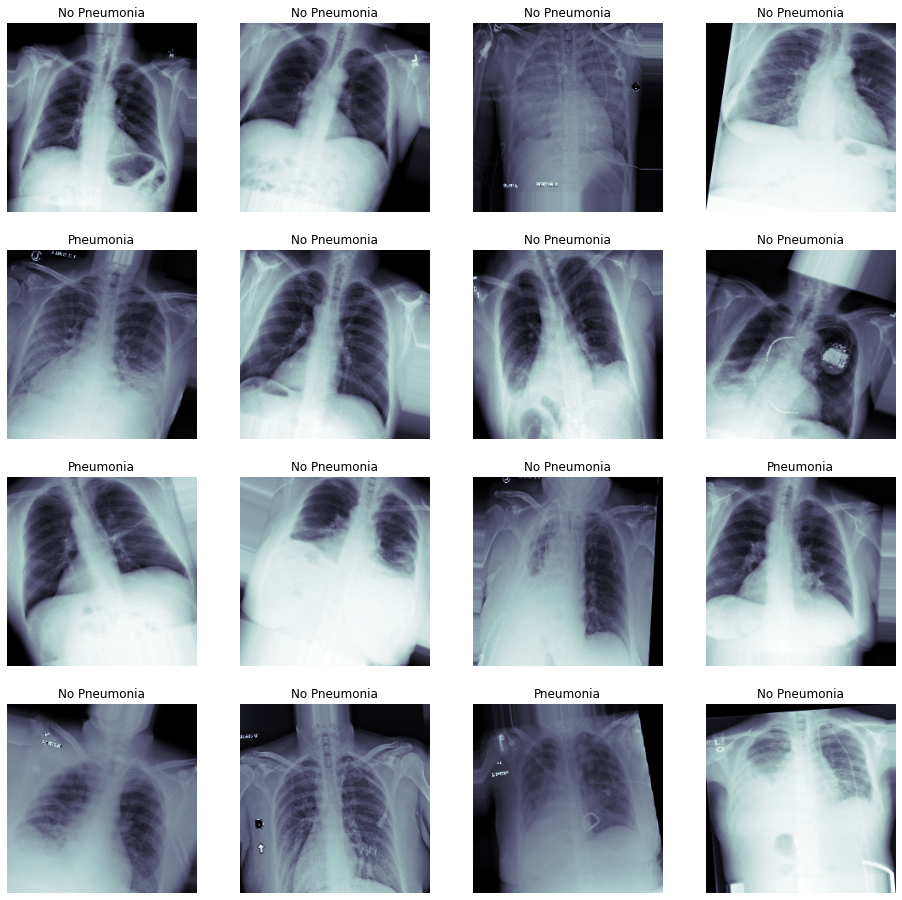

In [13]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [14]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    model = VGG16(include_top=True, weights='imagenet')
    print(model.summary())
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model


In [15]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    my_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    my_model.add(load_pretrained_model())

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(256, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    my_model.add(Dense(1, activation='sigmoid'))
    
    
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [16]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor = 'val_loss',
                             verbose=1, 
                             save_best_only=True, 
                             mode = 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor = 'val_loss', 
                      mode = 'min',
                      patience=10)

callbacks_list = [checkpoint, early]

In [17]:
my_model = build_my_model()

553467904/553467096 [==============================] - 9s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [18]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

### Start training! 

In [19]:
## train your model

history = my_model.fit_generator(train_gen, 
                                 validation_data = (valX, valY), 
                                 epochs = 32, 
                                 callbacks = callbacks_list)

Epoch 1/32
36/36 [==============================] - 33s 909ms/step - loss: 0.6678 - binary_accuracy: 0.6906 - val_loss: 0.5711 - val_binary_accuracy: 0.7188

Epoch 00001: val_loss improved from inf to 0.57105, saving model to xray_class_my_model.best.hdf5
Epoch 2/32
36/36 [==============================] - 29s 803ms/step - loss: 0.6019 - binary_accuracy: 0.7325 - val_loss: 0.5509 - val_binary_accuracy: 0.7188

Epoch 00002: val_loss improved from 0.57105 to 0.55089, saving model to xray_class_my_model.best.hdf5
Epoch 3/32
36/36 [==============================] - 29s 818ms/step - loss: 0.5804 - binary_accuracy: 0.7386 - val_loss: 0.5336 - val_binary_accuracy: 0.7188

Epoch 00003: val_loss improved from 0.55089 to 0.53357, saving model to xray_class_my_model.best.hdf5
Epoch 4/32
36/36 [==============================] - 29s 813ms/step - loss: 0.5740 - binary_accuracy: 0.7334 - val_loss: 0.5304 - val_binary_accuracy: 0.7188

Epoch 00004: val_loss improved from 0.53357 to 0.53041, saving mod

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [20]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 0s 14ms/step


In [21]:
plt.style.use("ggplot")

def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    plt.figure()
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    plt.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)), marker='o')
    #plt.text(fpr, tpr, thresholds)
    plt.legend()
    plt.xlabel('FPR: False positive rate')
    plt.ylabel('TPR: True positive rate')
    plt.grid()

## what other performance statistics do you want to include here besides AUC? 

# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(t_y, p_y):
    plt.figure()
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    plt.plot(precision, recall, label =  '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)), marker='o')
    #plt.text(precision, recall, thresholds)
    plt.legend()
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid()
    
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

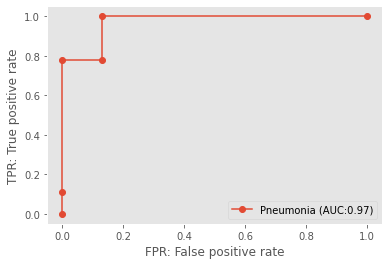

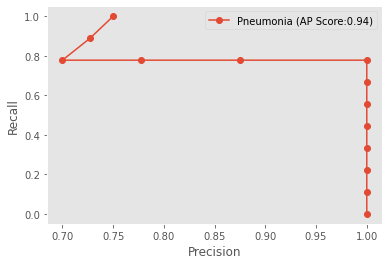

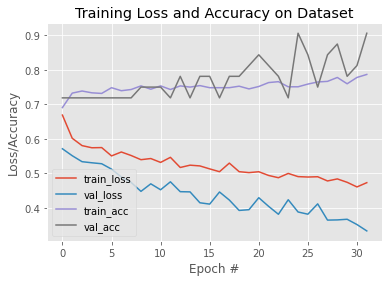

In [22]:
## plot figures
plot_auc(valY, pred_Y)
plot_precision_recall_curve(valY, pred_Y)
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [23]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

In [24]:
ths = np.arange(0.0, 1.0, 0.05)
accuracys = []
f1s = []
precisions = []
recalls = []

for th in ths:
    pred_Y_binary = [1 if i[0] > th else 0 for i in pred_Y]
    accuracy = accuracy_score(valY, pred_Y_binary)
    f1 = f1_score(valY, pred_Y_binary)
    precision = precision_score(valY, pred_Y_binary)
    recall = recall_score(valY, pred_Y_binary)
    
    print('---- threshold = ', th, '----')
    print('Accuracy = ', accuracy)
    print('F1 Score = ', f1)
    print('Precision = ', precision)
    print('Recall = ', recall)
    print('--------------------------------------')
    print('')
    
    accuracys.append(accuracy)
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)

---- threshold =  0.0 ----
Accuracy =  0.28125
F1 Score =  0.43902439024390244
Precision =  0.28125
Recall =  1.0
--------------------------------------

---- threshold =  0.05 ----
Accuracy =  0.4375
F1 Score =  0.5
Precision =  0.3333333333333333
Recall =  1.0
--------------------------------------

---- threshold =  0.1 ----
Accuracy =  0.59375
F1 Score =  0.5806451612903226
Precision =  0.4090909090909091
Recall =  1.0
--------------------------------------

---- threshold =  0.15000000000000002 ----
Accuracy =  0.65625
F1 Score =  0.6206896551724138
Precision =  0.45
Recall =  1.0
--------------------------------------

---- threshold =  0.2 ----
Accuracy =  0.75
F1 Score =  0.6923076923076924
Precision =  0.5294117647058824
Recall =  1.0
--------------------------------------

---- threshold =  0.25 ----
Accuracy =  0.78125
F1 Score =  0.72
Precision =  0.5625
Recall =  1.0
--------------------------------------

---- threshold =  0.30000000000000004 ----
Accuracy =  0.78125
F1 S

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0, 0.5, 'Accuracy')

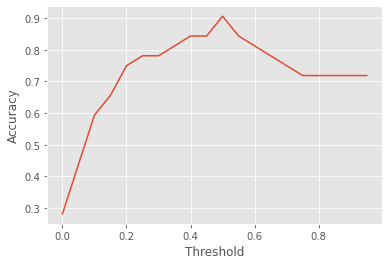

In [25]:
plt.plot(ths, accuracys)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

Text(0, 0.5, 'F1 Score')

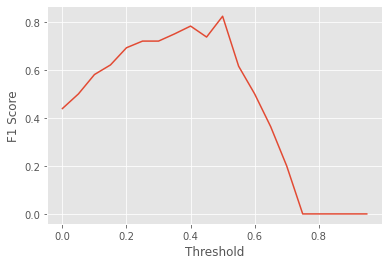

In [26]:
plt.plot(ths, f1s)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')

Text(0, 0.5, 'Precision')

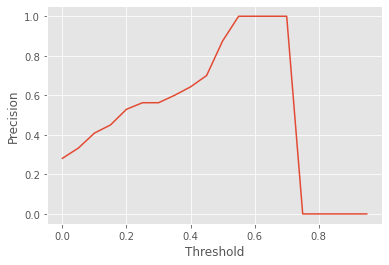

In [27]:
plt.plot(ths, precisions)
plt.xlabel('Threshold')
plt.ylabel('Precision')

Text(0, 0.5, 'Recall')

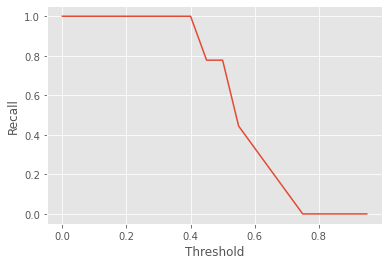

In [28]:
plt.plot(ths, recalls)
plt.xlabel('Threshold')
plt.ylabel('Recall')

In [29]:
# precision, recall, threshold = precision_recall_curve(valY, pred_Y)

In [30]:
# precision_value = 0.8
# idx = (np.abs(precision - precision_value)).argmin() 
# print('Precision is: '+ str(precision[idx]))
# print('Recall is: '+ str(recall[idx]))
# print('Threshold is: '+ str(threshold[idx]))
# print('F1 Score is: ' + str(f1_score(precision[idx],recall[idx])))

In [31]:
# recall_value = 0.8
# idx = (np.abs(recall - recall_value)).argmin() 
# print('Precision is: '+ str(precision[idx]))
# print('Recall is: '+ str(recall[idx]))
# print('Threshold is: '+ str(threshold[idx]))
# print('F1 Score is: ' + str(precision_score(precision[idx],recall[idx])))

In [32]:
# accuracy_score(valY, pred_Y>0.79)

In [33]:
# accuracy_score(valY, pred_Y>0.39)

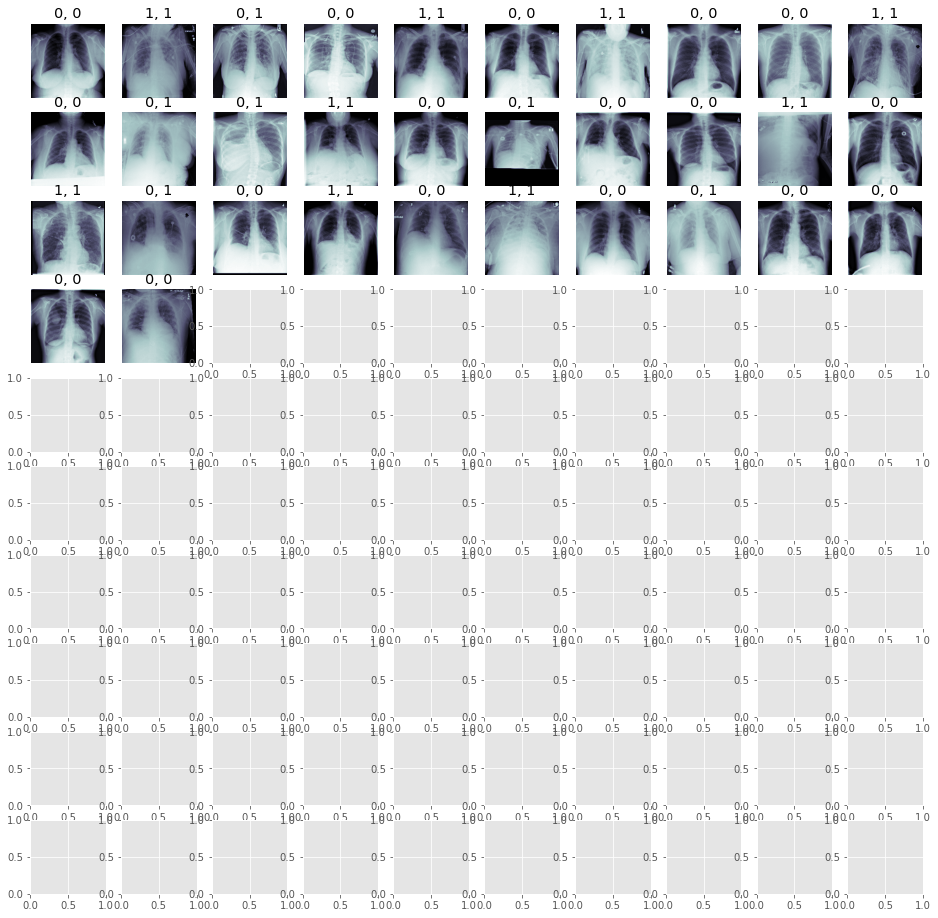

In [34]:
## Let's look at some examples of true vs. predicted with our best model: 

THRESHOLD = 0.35

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [35]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)